# Tutorial: Calculating Fe XIII Density using EISPAC

This notebook demonstrates how to calculate the density of Fe XIII using the EISPAC package in Python. It reads in EIS data, fits the spectra using Fe XIII templates, calculates the intensity ratio of the 203.83 Å and 202.04 Å lines, and converts the ratio to density values using a pre-calculated density ratio table.

## Import necessary libraries
- Import required Python libraries: scipy.io, eispac, numpy, os, matplotlib.pyplot, and scipy.io.readsav

In [1]:
import scipy.io as io
import eispac
import numpy as np 
import os 
import matplotlib.pyplot as plt
from scipy.io import readsav


## Set data directory and file name
- Define the directory and file name of the EIS data to be analyzed

In [5]:
data_dir = '/Users/andysh.to/Downloads/'
data_name = 'eis_20221020_034349.data.h5'
data_filepath = os.path.join(data_dir,data_name)

## Read Fe XIII templates
- Read in the Fe XIII 203.83 Å and 202.04 Å templates using the `eispac.read_template()` function
- Create a directory named 'fit_res' to store the fit results, if it doesn't already exist



In [6]:
## Read that file 
# Fe XIII 203.83 Template
my_template_filename_203 = 'my_Fe_XIII_template-3c.h5'
FeXIII_203_tmplt = eispac.read_template(my_template_filename_203)

# Fe XIII 202.04 Template
template_filename_202 = 'fe_13_202_044.1c.template.h5'
FEXIII_202_tmplt = eispac.read_template(eispac.data.get_fit_template_filepath(template_filename_202))

# Create the directory 'fit_res' if it doesn't exist
os.makedirs('fit_res', exist_ok=True)


## Read spectral window and fit the data
- Loop through the Fe XIII templates
 - Read the spectral window into an EISCube using `eispac.read_cube()`
 - Fit the data using `eispac.fit_spectra()` and save the results to disk using `eispac.save_fit()`
 - Append the fit results to the `all_fits` list


In [7]:
# Read spectral window into an EISCube
all_fits = []
for template in [FeXIII_203_tmplt, FEXIII_202_tmplt]:
    data_cube = eispac.read_cube(data_filepath, template.central_wave,
                                  apply_radcal=True) 
    
    # Fit the data, then save it to disk
    save_dir = 'fit_res/'
    fit_res = eispac.fit_spectra(data_cube, template, ncpu='max')
    fit_res.fit['int'] = fit_res.shift2wave(fit_res.fit['int'],wave=195.119)
    save_filepaths = eispac.save_fit(fit_res, save_dir=save_dir)
    all_fits.append(fit_res)

Data file,
   /Users/andysh.to/Downloads/eis_20221020_034349.data.h5
Header file,
   /Users/andysh.to/Downloads/eis_20221020_034349.head.h5
Found a wavelength 203.78 [Angstroms] in window 12
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
 + computing fits for 62 exposures, each with 512 spectra
 + running mpfit on 12 cores (of 12)
 + working on exposure 062

Finished computing fits!
   runtime : 0:00:18.851866
   31744 spectra fit without issues
   0 spectra have < 10 good data points
   0 spectra have bad or invalid parameters
Saving EIS fit results...
   Directory: fit_res
   Filenames: eis_20221020_034349.fe_13_203_710.3c-0.fit.h5
              eis_20221020_034349.fe_13_203_800.3c-1.fit.h5
              eis_20221020_034349.fe_13_203_830.3c-2.fit.h5
Data file,
   /Users/andysh.to/Downloads/eis_20221020_034349.data.h5
Header file,
   /Users/andysh.to/Downloads/eis_20221020_034349.head.h5
Found a wavelength 202.07 [Angstroms] in window 11
INFO: uncert

## Calculate density from intensity ratios
- Read in the pre-calculated density ratios and density values from an IDL .sav file
- Extract the intensity maps for the 203.83 Å and 202.04 Å lines from the fit results
- Calculate the observed intensity ratio of the two lines
- For each pixel in the observed ratio map, find the closest density ratio value and assign the corresponding density value


In [8]:
density_ratios = readsav('density_ratios_fe_13_203_82_202_04_from_IDL.sav')['smooth_rat']
density_values = readsav('density_ratios_fe_13_203_82_202_04_from_IDL.sav')['smooth_den']

int_203 = all_fits[0].get_map(2,'int')
int_202 = all_fits[1].get_map(0,'int')

obs_ratio = int_203.data/int_202.data

for i in range(obs_ratio.shape[0]):
    for j in range(obs_ratio.shape[1]):
        obs = obs_ratio[i, j]
        closest_index = np.argmin(np.abs(density_ratios - obs))
        obs_ratio[i, j] = density_values[closest_index]
        

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


/var/folders/6w/c91jbrwd1k501xpqgh_czqbmvjj465/T/ipykernel_62711/3971544334.py:7: RuntimeWarning: invalid value encountered in divide
  obs_ratio = int_203.data/int_202.data


## Create a SunPy map of the density
- Create a SunPy map using the density values and the metadata from the 203.83 Å intensity map
- Set the metadata fields 'measrmnt', 'bunit', and 'line_id' to appropriate values
- Set the plot settings to normalize the density values between 8 and 10


In [9]:
import sunpy.map
from astropy.visualization import ImageNormalize

m = sunpy.map.Map(obs_ratio, int_203.meta)
m.meta['measrmnt'] = 'density'
m.meta['bunit'] = '' # probably want to change this to 1/cm3 in the future
m.meta['line_id'] = 'Fe XIII 203.83/202.04'
m.plot_settings['norm'] = ImageNormalize(vmin=8, vmax=10)


## Plot the density map
- Use the `peek()` method of the SunPy map to display the Fe XIII density map

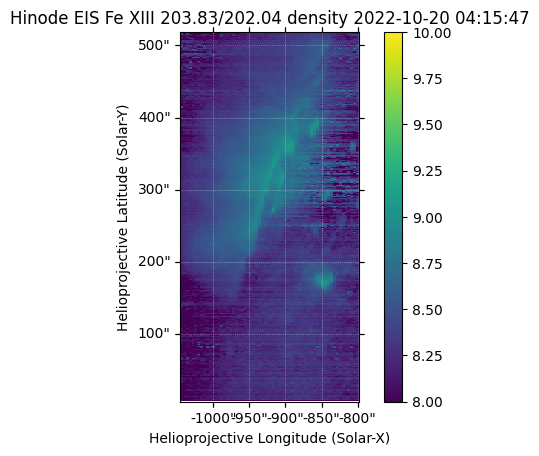

In [11]:
m.peek(cmap = 'viridis')